# Notebook 02: Regression Model

**Student Name:** David Fekke

**Dataset:** Exam Score Prediction

**Target Variable:** `exam_score`

**Checkpoint 3 Due:** Feb 15

---

## Rules & Integrity

1. **NO AI TOOLS**: You may **NOT** use ChatGPT, Claude, Gemini, GitHub Copilot, or any other AI assistant to generate code for this assignment. The goal is to build *your* fundamental skills. If you rely on AI now, the advanced topics later will be impossible.

2. **Study Groups Encouraged**: You **ARE** encouraged to discuss ideas, share approaches, and explain concepts to your study group peers. Teaching others is the best way to learn! However, the code you submit must be **your own work**.

3. **Use Your Resources**: You are free to use Google, StackOverflow, Pandas/Scikit-learn documentation, and your class notes.

4. **Comment Your Code**: Include comments explaining *why* you're doing what you're doing. I want to see your thought process.

5. **Resubmission**: You may submit this assignment multiple times for feedback before the checkpoint deadline.

---

## Important: Written Reflections

Throughout this notebook, you'll be asked to interpret results, justify decisions, and explain your reasoning. **These written reflections are a critical part of your grade.**

Good data scientists don't just run code—they communicate their findings clearly. Take time to write thoughtful, complete responses to all reflection prompts. This demonstrates your understanding and prepares you for real-world stakeholder communication.

---

## Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Sklearn - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Sklearn - evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model saving
import joblib

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 1: Load Processed Data

In [2]:
# Load cleaned data from previous notebook
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
df.head()

Data shape: (20000, 13)


,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,2.78,92.9,1,7.4,0,0,0,58.9,True,False,False,False,False
1,3.37,64.8,1,4.6,1,1,1,54.8,False,False,False,True,False
2,7.88,76.8,1,8.5,0,2,1,90.3,True,False,False,False,False
3,0.67,48.4,1,5.8,1,0,1,29.7,False,False,False,True,False
4,0.89,71.6,1,9.8,0,0,1,43.7,True,False,False,False,False


In [3]:
# Define your target variable
TARGET = 'exam_score'  # <-- UPDATE THIS!

print(f"Target: {TARGET}")
print(f"\nTarget statistics:")
print(df[TARGET].describe())

# Store target range for later interpretation
target_range = df[TARGET].max() - df[TARGET].min()
target_std = df[TARGET].std()
print(f"\nTarget range: {target_range:,.2f}")
print(f"Target std: {target_std:,.2f}")

Target: exam_score

Target statistics:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64

Target range: 80.40
Target std: 18.91


## Section 2: Prepare Features and Target

In [4]:
# Separate features (X) and target (y)
# I removed this column in the previous notebook
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nAll features ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (20000, 12)
Target shape: (20000,)

All features (12):
['study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'facility_rating', 'exam_difficulty', 'study_method_coaching', 'study_method_group study', 'study_method_mixed', 'study_method_online videos', 'study_method_self-study']


In [5]:
# Check for any non-numeric columns that need to be handled
non_numeric = X.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric:
    print(f"Warning: Non-numeric columns found: {non_numeric}")
    print("You need to encode these or go back to Notebook 01!")
else:
    print("All features are numeric. Ready to proceed!")

All features are numeric. Ready to proceed!


## Section 3: Train-Test Split

Split your data into training and test sets. The training set is used to train the model, and the test set is used to evaluate how well it generalizes to unseen data.

In [6]:
# TODO: Split your data into training and test sets
# 
# Requirements:
# - Use an 80/20 split (test_size=0.2)
# - Set random_state=42 for reproducibility
# - Store results in: X_train, X_test, y_train, y_test
#
# Hint: Use train_test_split(X, y, ...)

# YOUR CODE HERE:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
# Verify your split (run this cell to check)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

Training set: 16,000 samples (80%)
Test set: 4,000 samples (20%)


## Section 4: Feature Scaling

Many ML algorithms perform better when features are on similar scales. StandardScaler transforms features to have mean=0 and std=1.

**Important:** Fit the scaler on training data only, then transform both train and test. This prevents data leakage.

In [8]:
# TODO: Scale your features using StandardScaler
#
# Steps:
# 1. Create a StandardScaler instance
# 2. Fit the scaler on X_train and transform X_train (use fit_transform)
# 3. Transform X_test using the same scaler (use transform only - NOT fit_transform!)
# 4. Store results in: X_train_scaled, X_test_scaled
#
# Why fit only on train? To prevent "data leakage" - test data should be truly unseen.

# YOUR CODE HERE:
scaler_housing = StandardScaler()
X_train_scaled = scaler_housing.fit_transform(X_train)
X_test_scaled = scaler_housing.transform(X_test)
X_train.head()


,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
5894,6.87,57.1,0,9.0,2,0,0,False,True,False,False,False
3728,6.91,54.8,1,9.1,2,1,0,False,False,True,False,False
8958,5.45,99.4,1,7.6,1,1,1,False,True,False,False,False
7671,4.73,47.6,1,7.0,0,2,1,False,True,False,False,False
5999,3.81,78.6,1,7.8,2,2,1,False,True,False,False,False


In [9]:
# Convert back to DataFrame for easier viewing (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Verify scaling worked
print("Features scaled successfully!")
print(f"\nScaled feature means (should be ~0): {X_train_scaled.mean().mean():.4f}")
print(f"Scaled feature stds (should be ~1): {X_train_scaled.std().mean():.4f}")

Features scaled successfully!

Scaled feature means (should be ~0): 0.0000
Scaled feature stds (should be ~1): 1.0000


## Section 5: Baseline Model

Start with a simple Linear Regression to establish a baseline performance. This gives us a reference point for improvement.

In [14]:
# This helper function evaluates any model - you'll use it throughout this notebook
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train model and return evaluation metrics."""
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    results = {
        'Model': model_name,
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }
    
    return results, model, y_test_pred

In [15]:
# TODO: Create and evaluate a baseline Linear Regression model
#
# Steps:
# 1. Create a LinearRegression() model instance
# 2. Use the evaluate_model() function to train and evaluate it
# 3. Store the results
#
# The evaluate_model function returns: (results_dict, trained_model, predictions)

# YOUR CODE HERE:
# baseline_model = ...
# baseline_results, baseline_trained, baseline_preds = evaluate_model(...)

baseline_model = LinearRegression()
baseline_results, baseline_trained, baseline_preds = evaluate_model(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")

In [16]:
# Display baseline results
print("=" * 50)
print("BASELINE MODEL: Linear Regression")
print("=" * 50)
print(f"Train R²: {baseline_results['Train R2']:.4f}")
print(f"Test R²:  {baseline_results['Test R2']:.4f}")
print(f"Test RMSE: {baseline_results['Test RMSE']:,.2f}")
print(f"Test MAE: {baseline_results['Test MAE']:,.2f}")

# Context for RMSE
print(f"\n--- RMSE in Context ---")
print(f"RMSE as % of target range: {baseline_results['Test RMSE']/target_range*100:.1f}%")
print(f"RMSE as % of target std: {baseline_results['Test RMSE']/target_std*100:.1f}%")

BASELINE MODEL: Linear Regression
Train R²: 0.7319
Test R²:  0.7332
Test RMSE: 9.77
Test MAE: 7.86

--- RMSE in Context ---
RMSE as % of target range: 12.2%
RMSE as % of target std: 51.7%


### Baseline Interpretation

*Analyze your baseline results:*

**Understanding your metrics:**
- **R² (0 to 1)**: How much variance in target is explained by features. 0.7+ is often considered good.
- **RMSE**: Average prediction error in the same units as your target. Lower is better.
- **RMSE as % of range**: Helps you understand if errors are big or small relative to your data.

**Questions to answer:**
- What does your R² score tell you about how well features explain the target?
- Is there a big gap between train and test R²? (Gap > 0.1 could indicate overfitting)
- Is your RMSE reasonable? (e.g., if predicting house prices, is a $20K error acceptable?)

**Your interpretation:**

I had a 0.7332 for my Test R² score which was better than the 0.7. I believe this means my features are good for calculating a good prediction.
There was not a big gap between test and train score, so I do not believe that overfitting is an issue for my data. I only had a 12.2% range on my RMSE.

## Section 6: Model Iteration

Try at least 2-3 different models to see if you can improve on the baseline.

In [17]:
# Store all results for comparison
all_results = [baseline_results]

# Dictionary to store trained models
trained_models = {
    'Linear Regression (Baseline)': baseline_trained
}

### Model 2: Ridge Regression

Ridge adds L2 regularization to prevent overfitting by penalizing large coefficients.

In [18]:
# TODO: Create and evaluate a Ridge Regression model
#
# Create a Ridge model with alpha=1.0
# Use evaluate_model() to train and evaluate
# Add results to all_results list
# Add trained model to trained_models dict

# YOUR CODE HERE:
ridge_model = Ridge(alpha=1.0)
ridge_results, ridge_trained, ridge_preds = evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")

all_results.append(ridge_results)
trained_models['Ridge Regression'] = ridge_trained

# Print results
print(f"Ridge Regression - Test R²: {ridge_results['Test R2']:.4f}, Test RMSE: {ridge_results['Test RMSE']:,.2f}")

print(f"\n--- RMSE in Context ---")
print(f"RMSE as % of target range: {ridge_results['Test RMSE']/target_range*100:.1f}%")
print(f"RMSE as % of target std: {ridge_results['Test RMSE']/target_std*100:.1f}%")

Ridge Regression - Test R²: 0.7332, Test RMSE: 9.77

--- RMSE in Context ---
RMSE as % of target range: 12.1%
RMSE as % of target std: 51.7%


### Model 3: Lasso Regression

Lasso adds L1 regularization, which can zero out unimportant features (automatic feature selection).

In [19]:
# TODO: Create and evaluate a Lasso Regression model
#
# Create a Lasso model with alpha=0.1
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
lasso_model = Lasso(alpha=0.1)
lasso_results, lasso_trained, lasso_preds = evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")

all_results.append(lasso_results)
trained_models['Lasso Regression'] = lasso_trained

# Print results
print(f"Lasso Regression - Test R²: {lasso_results['Test R2']:.4f}, Test RMSE: {lasso_results['Test RMSE']:,.2f}")

# Show which features Lasso kept (non-zero coefficients)
lasso_coefs = pd.Series(lasso_trained.coef_, index=X.columns)
kept_features = lasso_coefs[lasso_coefs != 0]
print(f"\nLasso kept {len(kept_features)} of {len(X.columns)} features")

Lasso Regression - Test R²: 0.7329, Test RMSE: 9.77

Lasso kept 9 of 12 features


### Model 4: Decision Tree

In [20]:
# TODO: Create and evaluate a Decision Tree model
#
# Create a DecisionTreeRegressor with max_depth=10 and random_state=42
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_results, dt_trained, dt_preds = evaluate_model(dt_model, X_train_scaled, X_test_scaled, y_train, y_test, "Decision Tree")

all_results.append(dt_results)
trained_models['Decision Tree'] = dt_trained

# Print results
print(f"Decision Tree - Test R²: {dt_results['Test R2']:.4f}, Test RMSE: {dt_results['Test RMSE']:,.2f}")

Decision Tree - Test R²: 0.6321, Test RMSE: 11.47


### Model 5: Random Forest

In [21]:
# TODO: Create and evaluate a Random Forest model
#
# Create a RandomForestRegressor with:
#   - n_estimators=100
#   - max_depth=10
#   - random_state=42
#   - n_jobs=-1 (use all CPU cores)
#
# Use evaluate_model() to train and evaluate
# Add results to all_results and trained_models

# YOUR CODE HERE:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_results, rf_trained, rf_preds = evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest")

all_results.append(rf_results)
trained_models['Random Forest'] = rf_trained

# Print results
print(f"Random Forest - Test R²: {rf_results['Test R2']:.4f}, Test RMSE: {rf_results['Test RMSE']:,.2f}")

Random Forest - Test R²: 0.7084, Test RMSE: 10.21


### Add Your Own Model (Optional)

*Feel free to try additional models or tune hyperparameters!*

In [22]:
# YOUR ADDITIONAL MODEL HERE:
# Try GradientBoostingRegressor, different hyperparameters, etc.
xgb_model = GradientBoostingRegressor()
xgb_results, xgb_trained, xgb_preds = evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Gradient Boosting")

all_results.append(xgb_results)
trained_models['Gradient Boosting'] = xgb_trained

print(f"XGBoost - Test R²: {xgb_results['Test R2']:.4f}, Test RMSE: {xgb_results['Test RMSE']:,.2f}")


XGBoost - Test R²: 0.7286, Test RMSE: 9.85


## Section 7: Cross-Validation (More Robust Evaluation)

Cross-validation gives us a more reliable estimate of model performance by testing on multiple different train/test splits.

In [23]:
# Perform 5-fold cross-validation on top models
print("5-Fold Cross-Validation Results:")
print("=" * 50)

cv_results = []

models_to_cv = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

for name, model in models_to_cv.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    cv_results.append({
        'Model': name,
        'CV Mean R²': scores.mean(),
        'CV Std R²': scores.std()
    })
    print(f"{name}: R² = {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

cv_df = pd.DataFrame(cv_results)

5-Fold Cross-Validation Results:
Linear Regression: R² = 0.7314 (+/- 0.0144)
Ridge: R² = 0.7314 (+/- 0.0145)
Random Forest: R² = 0.7093 (+/- 0.0118)


**Why Cross-Validation Matters:**
- A model that performs well on one train/test split might just be lucky
- CV tests on 5 different splits, giving us confidence in the results
- Lower standard deviation = more consistent/reliable model

## Section 8: Model Comparison

In [24]:
# Create comparison DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
results_df = results_df.sort_values('Test R2', ascending=False)

print("Model Comparison:")
results_df

Model Comparison:


,Model,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,Linear Regression,0.7319,0.7332,9.7901,9.7690,7.8502,7.8623
1,Ridge Regression,0.7319,0.7332,9.7901,9.7687,7.8498,7.8616
2,Lasso Regression,0.7316,0.7329,9.7944,9.7737,7.8580,7.8724
5,Gradient Boosting,0.7427,0.7286,9.5907,9.8534,7.7007,7.9466
4,Random Forest,0.8129,0.7084,8.1772,10.2130,6.5826,8.2489
3,Decision Tree,0.7758,0.6321,8.9522,11.4714,7.0203,9.1770


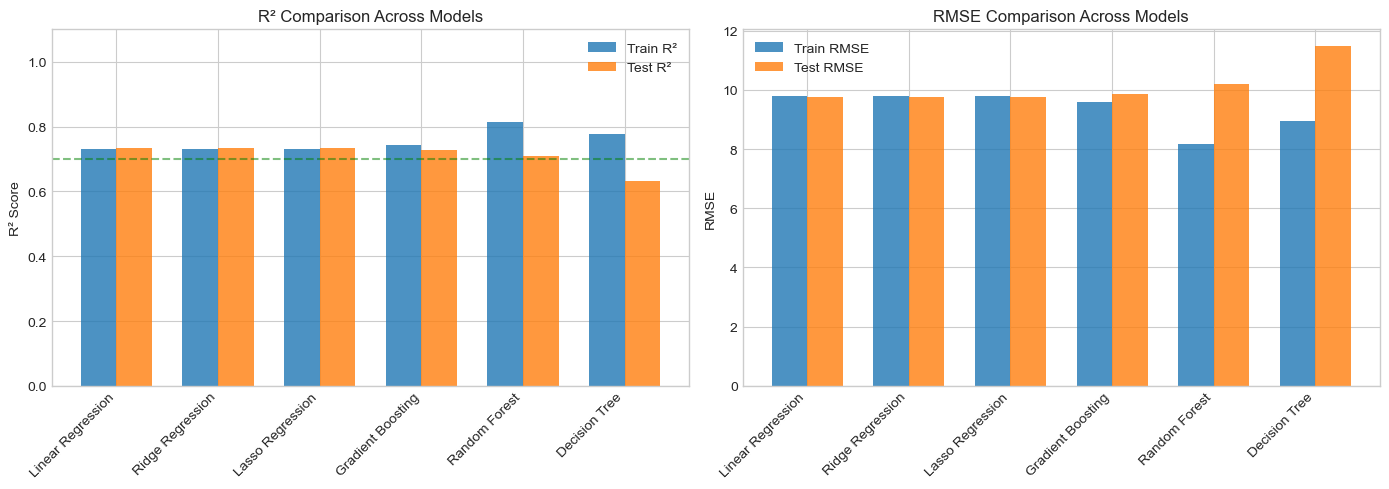

In [25]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
models = results_df['Model']
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, results_df['Train R2'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, results_df['Test R2'], width, label='Test R²', alpha=0.8)
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Comparison Across Models')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good threshold')

# RMSE Comparison
axes[1].bar(x - width/2, results_df['Train RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Test RMSE'], width, label='Test RMSE', alpha=0.8)
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE Comparison Across Models')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.show()

### Model Iteration Reflection

*Before selecting your best model, reflect on what you learned:*

**Questions to answer:**
- Which model improved most over the baseline?
- Did any models show signs of overfitting (big train vs test gap)?
- Did regularization (Ridge/Lasso) help or hurt performance?
- Did tree-based models (Decision Tree, Random Forest) work better than linear models?

**Your reflection:**

None of the models I have tried at this point have outperformed the Linear Regression model, but they all have come in over 70% accuracy with the exception of the DecisionTreeRegressor which was in the 60s, this may have do with overfitting. Regularization did not have any noticeable affect on performance. The Tree models underperformed. 

## Section 9: Feature Importance & Selection

**Important:** Your final model should use only **4-8 features**. This section helps you identify which features matter most.

Feature Importance (Random Forest):
                       Feature  Importance
0                  study_hours    0.666565
1             class_attendance    0.153356
4                sleep_quality    0.047378
3                  sleep_hours    0.046808
5              facility_rating    0.034363
7        study_method_coaching    0.031927
6              exam_difficulty    0.004941
9           study_method_mixed    0.004437
11     study_method_self-study    0.003696
2              internet_access    0.002540
10  study_method_online videos    0.002429
8     study_method_group study    0.001561


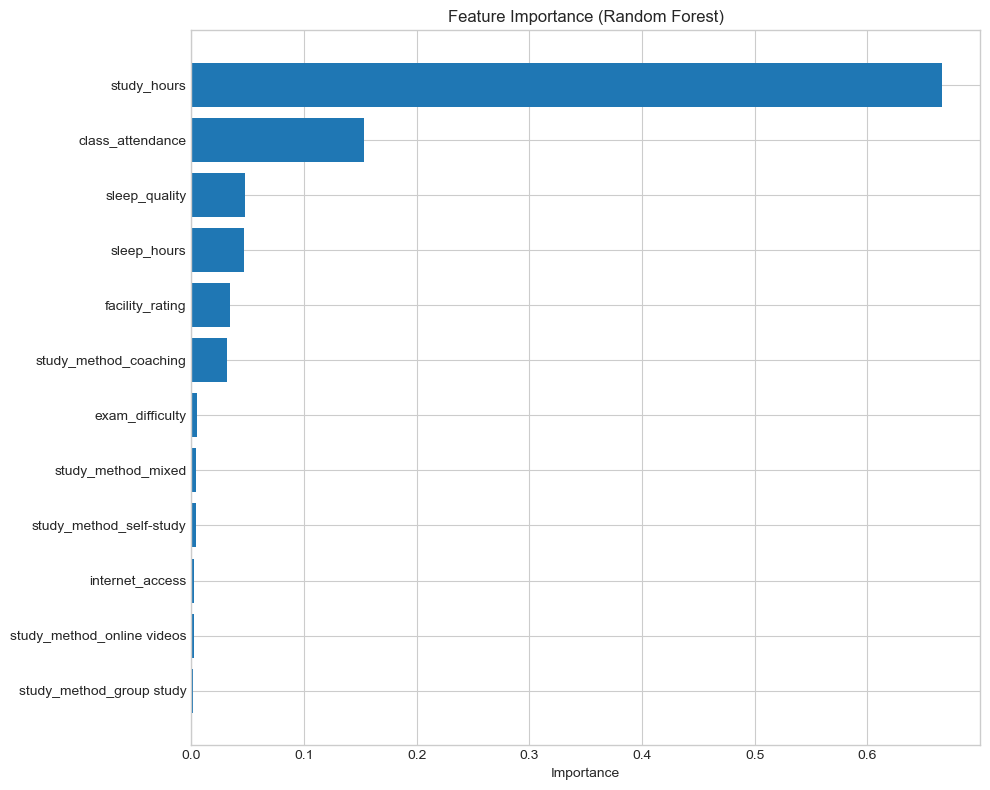

In [26]:
# Get feature importance from Random Forest (works well for this)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_trained.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(rf_importance)

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['Feature'][::-1], rf_importance['Importance'][::-1])
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [27]:
# Also check correlations with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print("Absolute Correlations with Target:")
print(correlations)

Absolute Correlations with Target:
study_hours                   0.716166
class_attendance              0.314932
sleep_quality                 0.196509
study_method_coaching         0.164676
facility_rating               0.162930
sleep_hours                   0.130854
study_method_self-study       0.102005
study_method_online videos    0.059589
study_method_group study      0.042345
study_method_mixed            0.040794
exam_difficulty               0.010832
internet_access               0.000550
dtype: float64


In [28]:
# TODO: Select your top features (4-8 features)
#
# Based on the importance analysis above, choose your best features.
# Consider both Random Forest importance AND correlations.
# Also think about what makes sense from a domain perspective.

SELECTED_FEATURES = [
    'study_hours',                   # 0.716166
    'class_attendance',              # 0.314932
    'sleep_quality',                 # 0.196509
    'study_method_coaching',         # 0.164676
    'facility_rating',                # 0.162930
    'sleep_hours'                   #0.130854
]

# Fallback if you haven't selected yet
if len(SELECTED_FEATURES) == 0:
    SELECTED_FEATURES = rf_importance['Feature'].head(6).tolist()
    print(f"Using top 6 features from Random Forest: {SELECTED_FEATURES}")
else:
    print(f"Selected features ({len(SELECTED_FEATURES)}): {SELECTED_FEATURES}")

Selected features (6): ['study_hours', 'class_attendance', 'sleep_quality', 'study_method_coaching', 'facility_rating', 'sleep_hours']


In [29]:
# Retrain with selected features only
X_train_selected = X_train_scaled[SELECTED_FEATURES]
X_test_selected = X_test_scaled[SELECTED_FEATURES]

print(f"Training with {len(SELECTED_FEATURES)} selected features...")

# Test a few models with selected features
selected_results = []

for name, model in [('Linear Regression', LinearRegression()),
                    ('Ridge', Ridge(alpha=1.0)),
                    ('Random Forest', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))]:
    results, trained, _ = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test, name)
    selected_results.append(results)
    print(f"{name} with {len(SELECTED_FEATURES)} features - Test R²: {results['Test R2']:.4f}")

selected_df = pd.DataFrame(selected_results)

Training with 6 selected features...
Linear Regression with 6 features - Test R²: 0.7251
Ridge with 6 features - Test R²: 0.7251
Random Forest with 6 features - Test R²: 0.7044


### Feature Selection Justification

**Questions to answer:**
- Which features did you select and why?
- Did performance drop significantly with fewer features?
- Do these features make sense from a domain perspective?
- These are the features users will input in your Streamlit app—are they reasonable to ask for?

**Your justification:**

I selected the top 5 features because they had between 15% correlations. The performance did not significantly drop after choosing these five. The features all fit within the domain of criteria we might use for a model. This could be used in a Streamlit app to demonstrate the models predictions.

## Section 10: Best Model Selection

In [30]:
# TODO: Choose and train your final model with selected features
#
# Based on your analysis, pick the best model type and instantiate it.
# Consider: performance, consistency, simplicity
#
# Example: final_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# YOUR CODE HERE:
# final_model = ...
final_model = LinearRegression()


In [31]:
# Fit and evaluate final model
final_model.fit(X_train_selected, y_train)
y_pred = final_model.predict(X_test_selected)

# Final metrics
final_r2 = r2_score(y_test, y_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Model: {type(final_model).__name__}")
print(f"Features: {SELECTED_FEATURES}")
print(f"\nTest R²: {final_r2:.4f}")
print(f"Test RMSE: {final_rmse:,.2f}")
print(f"Test MAE: {final_mae:,.2f}")
print(f"\nRMSE as % of target range: {final_rmse/target_range*100:.1f}%")

FINAL MODEL PERFORMANCE
Model: LinearRegression
Features: ['study_hours', 'class_attendance', 'sleep_quality', 'study_method_coaching', 'facility_rating', 'sleep_hours']

Test R²: 0.7251
Test RMSE: 9.92
Test MAE: 7.98

RMSE as % of target range: 12.3%


### Best Model Justification

*Explain why you chose this model as your best:*

**Questions to consider:**
- Why did you select this model over others?
- Is there significant overfitting (train vs test gap)?
- How does the performance compare to your baseline?
- Would a simpler model be almost as good?
- Does the RMSE represent acceptable prediction error for your problem?

**Your justification:**

The Linear Regression model performed the best out of the models I have tried so far. There does not appear to be any overfitting. The performance came in within a percentage point of my baseline. In this case the simpler model is the best model. The RMSE was 9.92.

## Section 11: Best Model Analysis

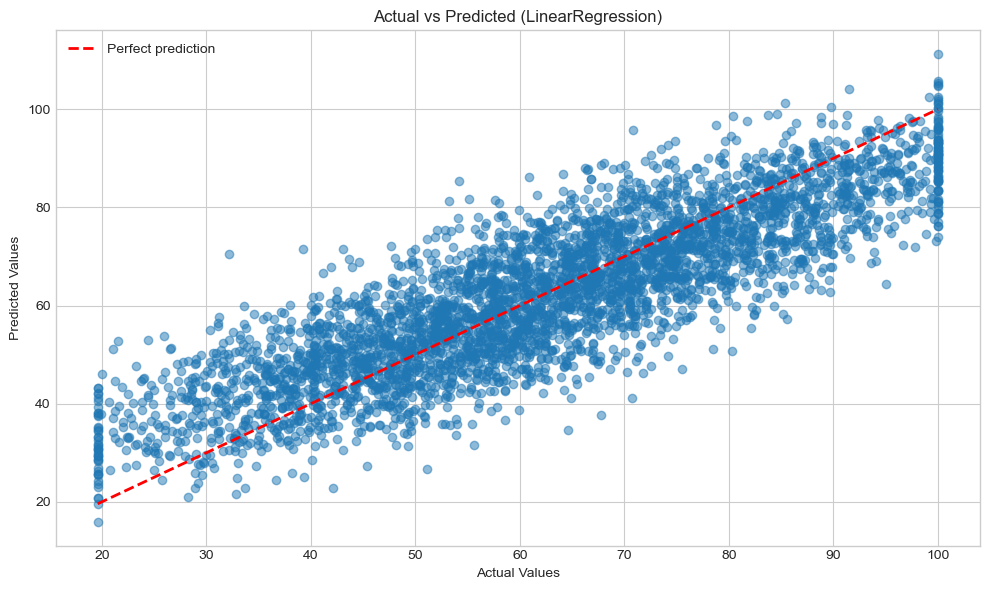

In [32]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted ({type(final_model).__name__})')
plt.legend()
plt.tight_layout()
plt.show()

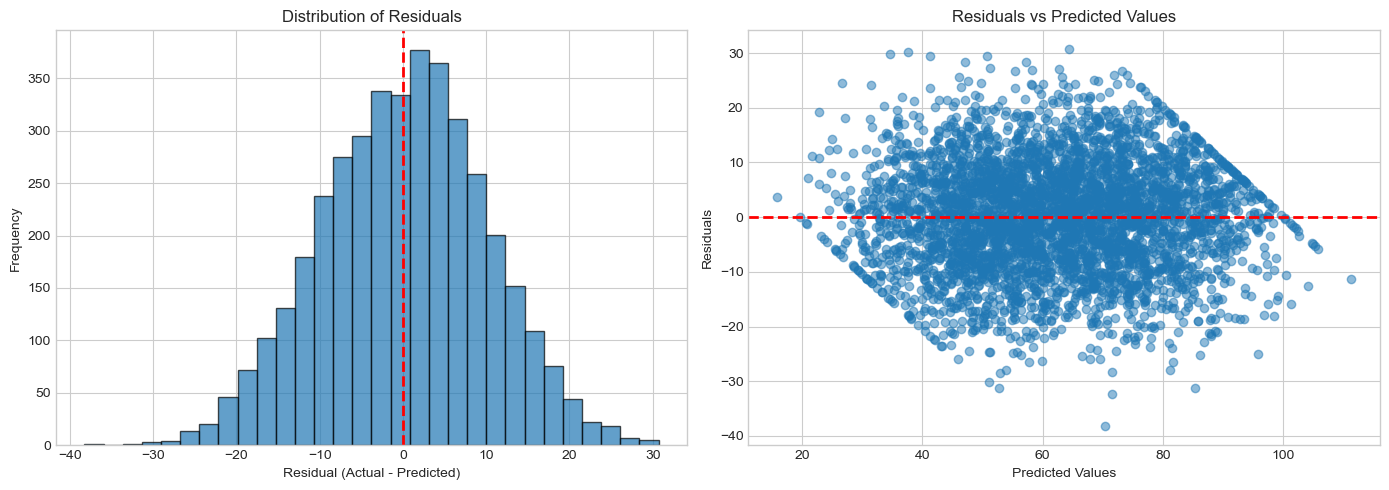

Residual mean (should be ~0): 0.12
Residual std: 9.92


In [33]:
# Residual analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution (should be roughly normal, centered at 0)
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')

# Residuals vs Predicted (should show no pattern)
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

print(f"Residual mean (should be ~0): {residuals.mean():.2f}")
print(f"Residual std: {residuals.std():,.2f}")

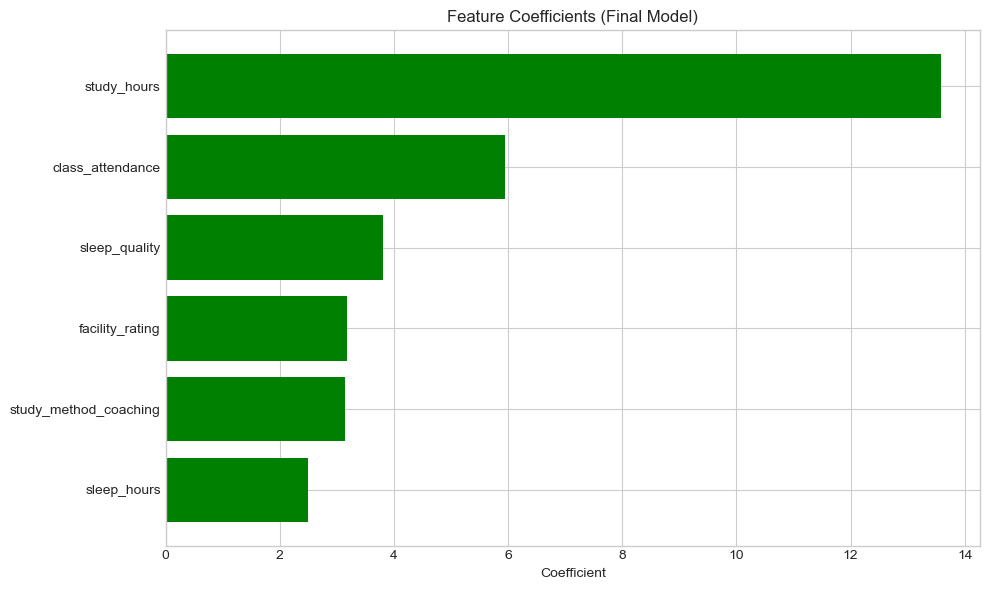

In [34]:
# Feature importance for final model (with selected features)
if hasattr(final_model, 'feature_importances_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(final_importance['Feature'], final_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Final Model)')
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'coef_'):
    final_importance = pd.DataFrame({
        'Feature': SELECTED_FEATURES,
        'Coefficient': final_model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in final_importance['Coefficient']]
    plt.barh(final_importance['Feature'], final_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient')
    plt.title('Feature Coefficients (Final Model)')
    plt.tight_layout()
    plt.show()

## Section 12: Save Model and Artifacts

In [35]:
# Create a new scaler fitted only on selected features
final_scaler = StandardScaler()
X_train_final = X_train[SELECTED_FEATURES]
final_scaler.fit(X_train_final)

# Save the best model
model_path = '../models/regression_model.pkl'
joblib.dump(final_model, model_path)
print(f"Model saved to {model_path}")

# Save the scaler (fitted on selected features only)
scaler_path = '../models/regression_scaler.pkl'
joblib.dump(final_scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save feature names (the selected features for Streamlit app)
features_path = '../models/regression_features.pkl'
joblib.dump(SELECTED_FEATURES, features_path)
print(f"Features saved to {features_path}")

Model saved to ../models/regression_model.pkl
Scaler saved to ../models/regression_scaler.pkl
Features saved to ../models/regression_features.pkl


In [36]:
# Verify saved model works
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
loaded_features = joblib.load(features_path)

# Test prediction
test_sample = X_test[loaded_features].iloc[[0]]
test_sample_scaled = loaded_scaler.transform(test_sample)
test_pred = loaded_model.predict(test_sample_scaled)

print(f"\nModel verification:")
print(f"Features used: {loaded_features}")
print(f"Sample input: {test_sample.values[0]}")
print(f"Predicted: {test_pred[0]:,.2f}")
print(f"Actual: {y_test.iloc[0]:,.2f}")
print(f"\nModel saved and verified successfully!")


Model verification:
Features used: ['study_hours', 'class_attendance', 'sleep_quality', 'study_method_coaching', 'facility_rating', 'sleep_hours']
Sample input: [2.01 48.2 0 False 1 4.9]
Predicted: 33.96
Actual: 31.10

Model saved and verified successfully!


## Section 13: Binning Strategy for Classification

**IMPORTANT:** Before you start Notebook 03, you need to send your binning strategy to Abishek on Slack for approval by **Feb 15**.

### Analyze Target Distribution

In [37]:
# Look at target distribution to help decide binning
print(f"Target: {TARGET}")
print(f"\nDescriptive Statistics:")
print(y.describe())

print(f"\nPercentiles:")
for p in [10, 25, 33, 50, 67, 75, 90]:
    print(f"{p}th percentile: {y.quantile(p/100):,.2f}")

Target: exam_score

Descriptive Statistics:
count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64

Percentiles:
10th percentile: 37.40
25th percentile: 48.80
33th percentile: 53.50
50th percentile: 62.60
67th percentile: 71.60
75th percentile: 76.30
90th percentile: 88.00


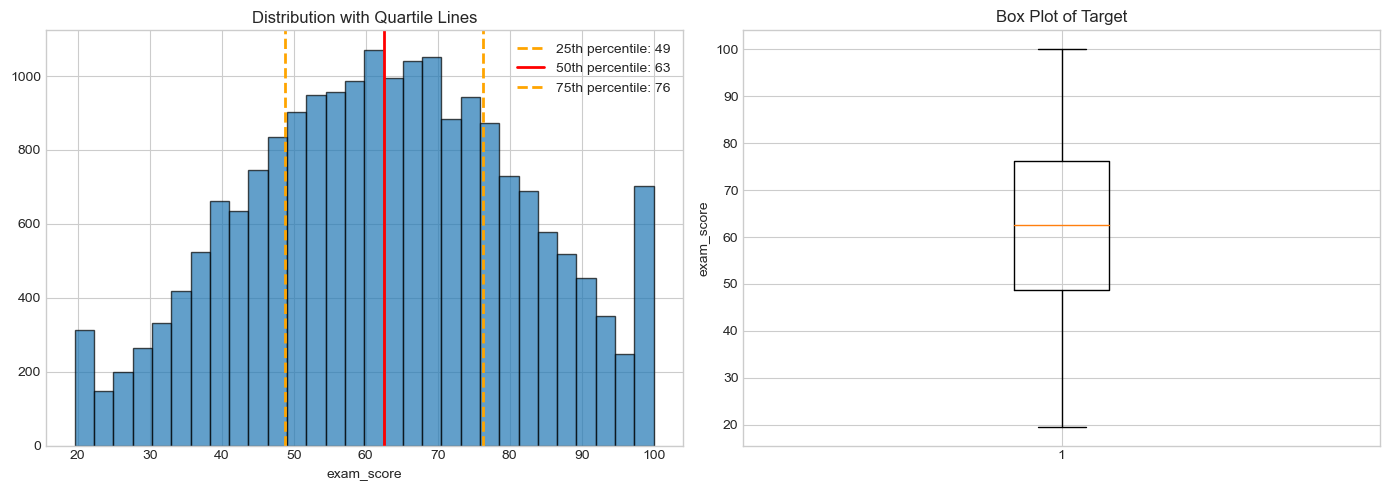

In [38]:
# Visualize potential binning strategies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with quartile lines
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
for p, color, style in [(25, 'orange', '--'), (50, 'red', '-'), (75, 'orange', '--')]:
    axes[0].axvline(y.quantile(p/100), color=color, linestyle=style, linewidth=2,
                     label=f'{p}th percentile: {y.quantile(p/100):,.0f}')
axes[0].set_xlabel(TARGET)
axes[0].set_title('Distribution with Quartile Lines')
axes[0].legend()

# Box plot
axes[1].boxplot(y)
axes[1].set_ylabel(TARGET)
axes[1].set_title('Box Plot of Target')

plt.tight_layout()
plt.show()

### Proposed Binning Strategy

*Complete this section and send to Abishek on Slack by Feb 15:*

**1. How many categories will you create?**

I will create five categories for the exam grade. 

**2. What are your bin thresholds?**

The thresholds will be A: 100-90, B: 89-80, C: 79-70, D: 69-60 and F: <60

**3. Why does this binning make sense for your problem?**

Because is will be based on the letter score.

In [39]:
# Preview your binning
def create_bins_preview(y, strategy='quartile'):
    if strategy == 'quartile':
        bins = [y.min()-1, y.quantile(0.25), y.quantile(0.75), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    elif strategy == 'tertile':
        bins = [y.min()-1, y.quantile(0.33), y.quantile(0.67), y.max()+1]
        labels = ['Low', 'Medium', 'High']
    # Add your custom strategy here if needed
    
    return pd.cut(y, bins=bins, labels=labels)

# Preview with quartile binning
y_binned = create_bins_preview(y, 'quartile')
print("Preview of binned target (using quartiles):")
print(y_binned.value_counts().sort_index())
print(f"\nPercentages:")
print((y_binned.value_counts(normalize=True) * 100).round(1).sort_index())

Preview of binned target (using quartiles):
exam_score
Low        5009
Medium    10030
High       4961
Name: count, dtype: int64

Percentages:
exam_score
Low       25.0
Medium    50.1
High      24.8
Name: proportion, dtype: float64


---

## Summary

### What You Accomplished
- [ ] Loaded and prepared cleaned data
- [ ] Split data into train and test sets
- [ ] Scaled features appropriately
- [ ] Built a baseline model
- [ ] Tried multiple model types
- [ ] Performed cross-validation
- [ ] Selected top 4-8 features
- [ ] Compared and selected best model
- [ ] Analyzed model performance (residuals, feature importance)
- [ ] Saved model, scaler, and feature list
- [ ] Planned binning strategy for classification

### Key Results

**Best Model:** LinearRegression

**Selected Features:**  'study_hours', 'class_attendance', 'sleep_quality', 'study_method_coaching', 'facility_rating', 'sleep_hours'  

**Test R²:** 0.7251

**Test RMSE:** 9.85

**Improvement over baseline:** There was no improvement over baseline.

---

---

## Checkpoint 3 Submission Instructions

**Congratulations!** You've completed Checkpoint 3 (Regression Model).

### Step 1: Save This Notebook
- File -> Save (or Ctrl+S / Cmd+S)

### Step 2: Send Binning Strategy to Abishek
- Message Abishek on Slack with your binning strategy
- Include: number of categories, thresholds, and justification

### Step 3: Commit to GitHub

```bash
# Stage your changes
git add notebooks/02_regression_model.ipynb
git add models/

# Commit with a meaningful message
git commit -m "Complete Checkpoint 3: Regression model with feature selection"

# Push to GitHub
git push
```

### Step 4: Submit to Canvas
1. Go to the Checkpoint 3 assignment on Canvas
2. Submit the link to your GitHub repository

---

## Next Steps

1. **Wait for binning approval** from Abishek
2. Move on to **Notebook 03: Classification Model**

---